<a href="https://colab.research.google.com/github/Jamnic98/blue-cheese-classifier/blob/main/blue_cheese_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import modules, mount the google drive and establish constants

In [20]:
# import modules
import os
import numpy as np
import shutil
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from contextlib import redirect_stdout

# mount the google drive and change directory
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/

# constants
VAL_RATIO = 0.05
TEST_RATIO = 0.10
ROOT_DIR = '/content/drive/MyDrive/'
CLASS_NAMES = ['blueCheese', 'notBlueCheese']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive


## Split images into train, test and validation folders

In [12]:
data_dir = ROOT_DIR +'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

for class_name in CLASS_NAMES:
  # create train folders
  train_dir = data_dir + 'train/'
  if not os.path.isdir(train_dir):
    os.mkdir(train_dir)
  class_train_dir = train_dir + class_name
  if not os.path.isdir(class_train_dir):
    os.mkdir(class_train_dir)
  # create test folders
  test_dir = data_dir + 'test/'
  if not os.path.isdir(test_dir):
    os.mkdir(test_dir)
  class_test_dir = test_dir + class_name
  if not os.path.isdir(class_test_dir):
    os.mkdir(class_test_dir)
  # create validation folders
  val_dir = data_dir + 'val/'
  if not os.path.isdir(val_dir):
    os.mkdir(val_dir)
  class_val_dir = val_dir + class_name
  if not os.path.isdir(class_val_dir):
    os.mkdir(class_val_dir)

  image_URIs = []
  # compile a complete list of image URIs
  cheese_names = os.listdir(ROOT_DIR + class_name)
  for cheese_name in cheese_names:
    cheese_dir = ROOT_DIR + 'cheeses/' + class_name + '/'
    image_URIs.extend(
      [cheese_dir + cheese_image for cheese_image in os.listdir(cheese_dir)]
    )

  # shuffle image URIs
  np.random.shuffle(image_URIs)

  # split the data into train, test and validation sets
  train_URIs, test_URIs, val_URIs = np.split(
    np.array(image_URIs),
    [int(len(image_URIs)* (1 - (VAL_RATIO + TEST_RATIO))), 
    int(len(image_URIs)* (1 - VAL_RATIO))]
  )

  # # Copy-pasting images
  # for train_FileName in train_URIs.tolist():
  #   shutil.copy(train_FileName, class_train_dir)
  # for test_FileName in test_URIs.tolist():
  #   shutil.copy(test_FileName, class_test_dir)
  # for val_FileName in val_URIs.tolist():
  #   shutil.copy(val_FileName, class_val_dir)


## Generate augmented images and prepare training, testing and validation data

In [21]:
augmented_images_dir = ROOT_DIR + 'augmented_images/'
if not os.path.isdir(augmented_images_dir):
  os.mkdir(augmented_images_dir)

# augment the data that we have
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=15)

test_datagen = ImageDataGenerator(rescale=1./255)

# prepare training data
augmented_train_images_dir = augmented_images_dir + 'train/'
if not os.path.isdir(augmented_train_images_dir):
  os.mkdir(augmented_train_images_dir)
training_data = train_datagen.flow_from_directory('data/train',
                                                  # save_to_dir=augmented_train_images_dir,
                                                  target_size=(256, 256),
                                                  batch_size=32,
                                                  class_mode='categorical'
                                                  )

# prepare test data
augmented_test_images_dir = augmented_images_dir + 'test/'
if not os.path.isdir(augmented_test_images_dir):
  os.mkdir(augmented_test_images_dir)
test_data = test_datagen.flow_from_directory('data/test',
                                              # save_to_dir=augmented_test_images_dir,
                                              target_size = (256, 256),
                                              batch_size = 32,
                                              class_mode = 'categorical'
                                              )

# prepare validation data
augmented_val_images_dir = augmented_images_dir + 'val/'
if not os.path.isdir(augmented_val_images_dir):
  os.mkdir(augmented_val_images_dir)
validation_data = test_datagen.flow_from_directory('data/val',
                                                    # save_to_dir=augmented_val_images_dir,
                                                    target_size = (256, 256),
                                                    batch_size = 32,
                                                    class_mode = 'categorical'
                                                    )

Found 1206 images belonging to 2 classes.
Found 776 images belonging to 2 classes.
Found 476 images belonging to 2 classes.


## Build the model

In [22]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
# make 32 feature detectors with a size of 3x3
# choose the input-image's format to be 256x256 with 3 channels
classifier.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation="relu"))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(activation="relu", units=128))
classifier.add(Dense(activation="softmax", units=2))

# Compiling the CNN
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Train the model

In [23]:
history = classifier.fit(training_data,
               #steps_per_epoch = (10),
               epochs=200,
               validation_data=validation_data,
               validation_steps=10,
               callbacks=[EarlyStopping(monitor='loss', patience=5)])

Epoch 1/200
38/38 [==============================] - 24s 591ms/step - loss: 0.9652 - accuracy: 0.5288 - val_loss: 0.6442 - val_accuracy: 0.6281
Epoch 2/200
38/38 [==============================] - 22s 571ms/step - loss: 0.6247 - accuracy: 0.6407 - val_loss: 0.5725 - val_accuracy: 0.6687
Epoch 3/200
38/38 [==============================] - 22s 572ms/step - loss: 0.5734 - accuracy: 0.6823 - val_loss: 0.5532 - val_accuracy: 0.6687
Epoch 4/200
38/38 [==============================] - 22s 573ms/step - loss: 0.5594 - accuracy: 0.6940 - val_loss: 0.4668 - val_accuracy: 0.7812
Epoch 5/200
38/38 [==============================] - 22s 570ms/step - loss: 0.5051 - accuracy: 0.7676 - val_loss: 0.4579 - val_accuracy: 0.7750
Epoch 6/200
38/38 [==============================] - 22s 574ms/step - loss: 0.4535 - accuracy: 0.7982 - val_loss: 0.4404 - val_accuracy: 0.8000
Epoch 7/200
38/38 [==============================] - 22s 576ms/step - loss: 0.4360 - accuracy: 0.8068 - val_loss: 0.3348 - val_accuracy:

## Load a previously trained model

In [16]:
# from tensorflow import keras
# classifier = keras.models.load_model(ROOT_DIR + 'my_model14')

## Make predictions

In [29]:
# resize image
test_image = load_img('cheeses/notBlueCheese/brie137.jpg', target_size = (256, 256))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
print('Predicted class: ', int(result[0][0]))

predictions = classifier.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
confusion_matrix

Predicted class:  0
               precision    recall  f1-score   support

   blueCheese       0.56      0.55      0.56       413
notBlueCheese       0.50      0.51      0.50       363

     accuracy                           0.53       776
    macro avg       0.53      0.53      0.53       776
 weighted avg       0.53      0.53      0.53       776



array([[229, 184],
       [179, 184]])

25/25 - 3s - loss: 0.1849 - accuracy: 0.9317
Accuracy:  0.9317010045051575


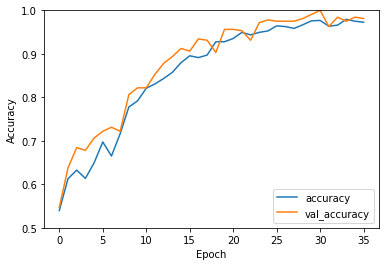

In [18]:
test_loss, test_acc = classifier.evaluate(test_data, verbose=2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

print('Accuracy: ', test_acc)

## Save the model

In [30]:
model_name = 'my_model15'
model_dir = ROOT_DIR + model_name + '/'
if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

with open(f'{model_dir}/{model_name}.txt', 'w') as file:
    with redirect_stdout(file):
        classifier.summary()

test_loss, test_acc = classifier.evaluate(test_data, verbose=2)
with open(f'{model_dir}/{model_name}.txt', 'a') as file:
  file.write(f'\nAccuracy: {test_acc}')
  file.write(f'\nReport\n: {report}')
  file.write(f'\nConfusion Matrix\n: {confusion_matrix}')
  
classifier.save(model_dir)

25/25 - 3s - loss: 0.0318 - accuracy: 0.9910
INFO:tensorflow:Assets written to: /content/drive/MyDrive/my_model15/assets
